In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"

data = Data()

data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../dataset/EthanT3/", postfix = "EthanT3", target=target)

data.include(data_path = "../../dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../dataset/EthenT3/", postfix = "EthenT3", target=target)

data.include(data_path = "../../dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

In [4]:
basis = "6-311++g**"
model_path="../../models/DescriptorH/" + target + "/"

# Descriptor 

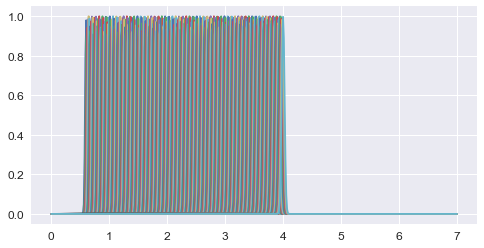

In [5]:
#from SCFInitialGuess.descriptors.models import make_uniform

def plot_normal_model(model, t):
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t, np.exp(-1 * eta*(t - r_s)**2))

def make_uniform(n, R_c=5, eta_max=30, eta_min=10):
    return (
        np.linspace(0.6,R_c*0.8, n),
        np.linspace(eta_max, eta_min, n),
    )
        
model = make_uniform(n=300, R_c=5, eta_min=800, eta_max=2000)
#model = make_uniform(n=50, R_c=5, eta_min=100, eta_max=30)
plot_normal_model(model, np.linspace(0, 7, 500))

In [6]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
    
import pickle

descriptor = AtomicNumberWeighted(
    #Gaussians(*RADIAL_GAUSSIAN_MODELS["Man"]),
    #Gaussians(*make_uniform(150, eta_max=200, eta_min=30)),
    Gaussians(*model),
    SPHAngularDescriptor(10),
    BehlerCutoff1(5)
)

pickle.dump(descriptor, open(model_path + "descriptor.dump", "wb"))

descriptor.radial_descriptor.number_of_descriptors, descriptor.angular_descriptor.number_of_descriptors, descriptor.number_of_descriptors

(300, 242, 542)

In [7]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
index=200
f = lambda x: x#(x[0][:index], x[0][index:(2*index)], x[2])

dataset = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "H"
)

np.save(model_path + "normalisation.npy", (dataset.x_mean, dataset.x_std))


In [8]:
np.mean(dataset.testing[1][0])

0.018127005714004826

In [9]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(26812, 6714, 8422)

In [10]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

x_train = AbstractDataset.denormalize(dataset.training[0], dataset.x_mean, dataset.x_std)
y_train = dataset.training[1]
np.mean(x_train[0] - x_train[-1])

0.0061783899038933355

## Autocorrelation 

In [11]:
dataset.training[0].shape

(26812, 542)

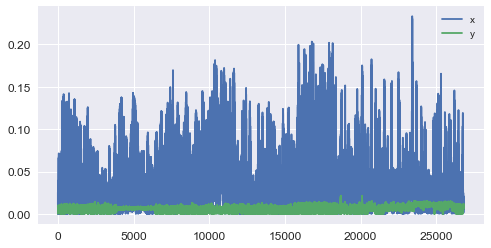

In [12]:

plt.plot(abs(np.mean(x_train[0] - x_train[1:], 1)), label="x")
plt.plot(abs(np.mean(y_train[0] - y_train[1:], 1)), label="y")

plt.legend()

## Variance

In [13]:
np.var(x_train, 0).shape

(542,)

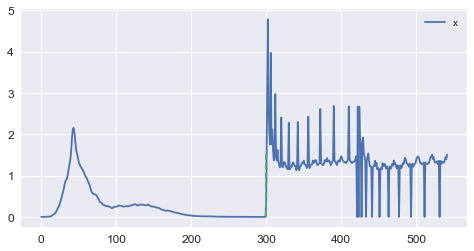

In [14]:
offset=0
plt.plot(np.var(x_train, 0)[offset:], label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors - offset]*2, [1e-3, 1.6], "--")

plt.legend()

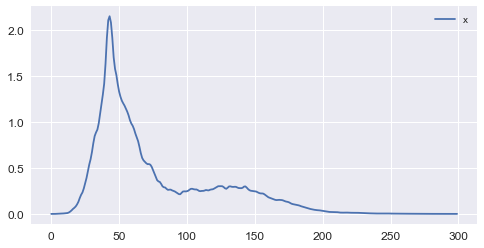

In [15]:
offset=0
plt.plot(np.var(x_train, 0)[offset:descriptor.radial_descriptor.number_of_descriptors], label="x")

plt.legend()

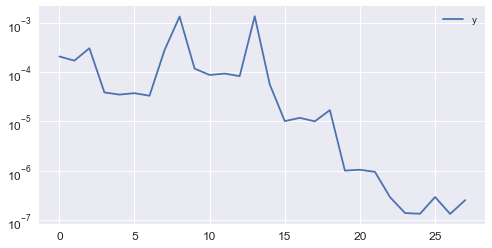

In [16]:
plt.semilogy(np.var(y_train, 0), label="y")
plt.legend()

# Average 

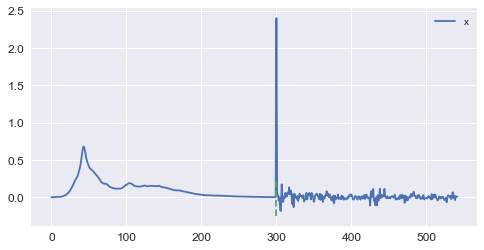

In [17]:
plt.plot(np.mean(x_train, 0), label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors]*2, [-0.25, 0.25], "--")

plt.legend()

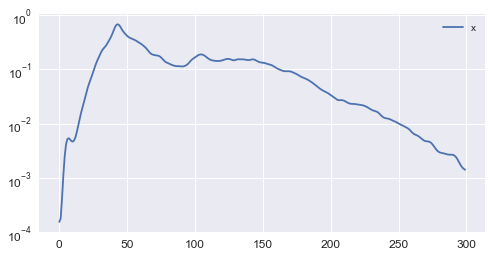

In [18]:
n_radial = descriptor.radial_descriptor.number_of_descriptors

plt.semilogy(np.mean(x_train, 0)[:n_radial], label="x")
#plt.plot([n_radial]*2, [-0.25, 0.25], "--")

plt.legend()

# Network Stuff 

In [20]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [21]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4, log_dir="./logs"):

    
    tensorboard = keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=0, 
        batch_size=32, 
        #update_freq='epoch'
    )
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                checkpoint,
                tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Actucal training 

In [22]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(26812, 6714, 8422)

In [23]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS


species = "H"

dim = N_BASIS[basis][species]
dim_triu = dim * (dim + 1) // 2


In [24]:
descriptor.number_of_descriptors, dim_triu

(542, 28)

In [30]:
structure = [700, 300]

In [31]:
keras.backend.clear_session()

In [32]:
model = make_model(
    structure=structure,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_triu,
    
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 700)               380100    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               210300    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8428      
Total params: 598,828
Trainable params: 598,828
Non-trainable params: 0
_________________________________________________________________


In [33]:
i =0
name_folder = "H_" + target  + ".h5"
name = target + "/500-10"

Train on 26812 samples, validate on 6714 samples
Epoch 1/1000
26812/26812 [==============================] - 22s 809us/step - loss: 0.0061 - mean_squared_error: 2.3306e-04 - val_loss: 9.9783e-05 - val_mean_squared_error: 8.2055e-05

Epoch 00001: val_mean_squared_error improved from inf to 0.00008, saving model to ../../models/DescriptorH/P/H_P.h5
Epoch 2/1000
26812/26812 [==============================] - 17s 652us/step - loss: 1.0972e-04 - mean_squared_error: 9.1236e-05 - val_loss: 9.2825e-05 - val_mean_squared_error: 7.6844e-05

Epoch 00002: val_mean_squared_error improved from 0.00008 to 0.00008, saving model to ../../models/DescriptorH/P/H_P.h5
Epoch 3/1000
26812/26812 [==============================] - 12s 463us/step - loss: 1.0453e-04 - mean_squared_error: 8.6397e-05 - val_loss: 9.3903e-05 - val_mean_squared_error: 7.4845e-05

Epoch 00003: val_mean_squared_error improved from 0.00008 to 0.00007, saving model to ../../models/DescriptorH/P/H_P.h5
Epoch 4/1000
26812/26812 [=========

26812/26812 [==============================] - 12s 447us/step - loss: 6.8943e-05 - mean_squared_error: 6.4186e-05 - val_loss: 6.6852e-05 - val_mean_squared_error: 6.2094e-05

Epoch 00029: val_mean_squared_error did not improve from 0.00006
Epoch 30/1000
26812/26812 [==============================] - 11s 418us/step - loss: 6.8943e-05 - mean_squared_error: 6.4186e-05 - val_loss: 6.6851e-05 - val_mean_squared_error: 6.2094e-05

Epoch 00030: val_mean_squared_error did not improve from 0.00006
Epoch 31/1000
26812/26812 [==============================] - 12s 446us/step - loss: 6.8943e-05 - mean_squared_error: 6.4186e-05 - val_loss: 6.6851e-05 - val_mean_squared_error: 6.2094e-05

Epoch 00031: val_mean_squared_error did not improve from 0.00006
Epoch 32/1000
26812/26812 [==============================] - 11s 426us/step - loss: 6.8943e-05 - mean_squared_error: 6.4186e-05 - val_loss: 6.6851e-05 - val_mean_squared_error: 6.2094e-05

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1e-10.

26812/26812 [==============================] - 18s 662us/step - loss: 5.8213e-05 - mean_squared_error: 5.2634e-05 - val_loss: 5.9781e-05 - val_mean_squared_error: 5.4199e-05

Epoch 00021: val_mean_squared_error improved from 0.00005 to 0.00005, saving model to ../../models/DescriptorH/P/H_P.h5
Epoch 22/1000
26812/26812 [==============================] - 16s 595us/step - loss: 5.8206e-05 - mean_squared_error: 5.2629e-05 - val_loss: 5.9777e-05 - val_mean_squared_error: 5.4201e-05

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00022: val_mean_squared_error did not improve from 0.00005
Epoch 23/1000
26812/26812 [==============================] - 13s 494us/step - loss: 5.8178e-05 - mean_squared_error: 5.2602e-05 - val_loss: 5.9777e-05 - val_mean_squared_error: 5.4201e-05

Epoch 00023: val_mean_squared_error did not improve from 0.00005
Epoch 24/1000
26812/26812 [==============================] - 12s 456us/step - loss: 5.8178e-05 - mean_squared_error

KeyboardInterrupt: 

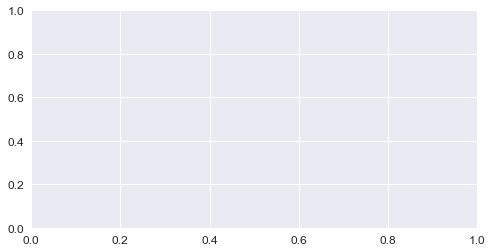

In [34]:
i+=1
train_model(
    model, 
    dataset, 
    model_path + name_folder,
    learning_rate=1e-4,
    log_dir="./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)